# **Kaggle Digit Recognizer**
## **Authors:**

- Cauê Caviglioni - [cauedanisilva@poli.ufrj.br](mailto:cauedanisilva@poli.ufrj.br)
- Erica Ferreira - [erica.ferreira@poli.ufrj.br](mailto:erica.ferreira@poli.ufrj.br)
- Bernardo Mendonça - [bernardomcaixeta@poli.ufrj.br](mailto:bernardomcaixeta@poli.ufrj.br)

## **Description:**
### In this notebook, it is used Neural Networks to recgnizer handwritten digits for the [Kaggle Digit Recognizer Competition](https://www.kaggle.com/c/digit-recognizer/data).

### This notebook was made by members of [UFRJ Analytica](https://ufrjanalytica.ml/), a Data Science Team from the Federal University of Rio de Janeiro

<hr>

## **Imports**

In [ ]:
from torch.utils.data                       import Dataset, DataLoader
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from sklearn.model_selection                import train_test_split

import pandas                               as pd
import numpy                                as np
import matplotlib.pyplot                    as plt
import torch.nn                             as nn
import torch.nn.functional                  as F
import torch.optim                          as optim

import torchvision
import torch

## **Importing Data**

In [ ]:
df_train = pd.read_table('../data/train.csv', sep=',')
df_test = pd.read_table('../data/test.csv', sep=',')

## **Preprocessing Data**

### **1. Data Conversion and reshaping images**

In [ ]:
train = np.array(df_train.drop(labels = ['label'], axis = 1), dtype = np.float32).reshape(-1, 28, 28, 1)
test = np.array(df_test, dtype = np.float32).reshape(-1, 28, 28, 1)

labels_train = df_train['label'].reshape(-1, 1)
labels_train = np.array(labels_train)

### **2. Value normalization of pixels**

In [ ]:
train = train / 255.0
test = test / 255.0

### **3. Group image and its label**

In [ ]:
class DataSettrain(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        if len(self.X) != len(self.Y):
            raise Exception("The size of X does not match the size of Y")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        _x = self.X[index]
        _y = self.Y[index]

        return _x, _y

### **4. Creating batch with pre defined size of images**

In [ ]:
loader = DataLoader(DataSettrain(train.reshape(42000, 1, 28, 28), labels_train), batch_size=50)
batch = next(iter(loader))
images, labels = batch

### Sample containing 50 images from the train dataset

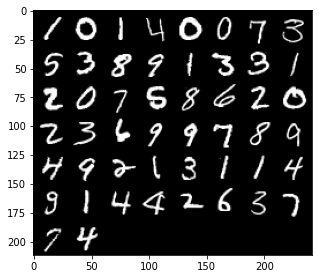

In [ ]:
grid = torchvision.utils.make_grid(images, n_row = 10)

plt.figure(figsize=(5,5))
plt.imshow(np.transpose(torch.FloatTensor(grid), (1,2,0)))
plt.show()

## **Expand training data**

### New images will be generated from the available training data, and thus, boost the neural network performance

### **1. Image Generation**

### Generaring 10 variations from each image in the training dataset

In [ ]:
images_extras = []
labels_images_extras = []
img_new = []
label_img_new = []

# Creating an object to generate new images from the initial dataset
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.10, width_shift_range=0.1, height_shift_range=0.1)

for j in range(len(train)):
    for i in range(10):
        X_train = train[j].reshape(1,28,28,1)
        label_img_new = labels_train[j]
            
        X_train2, Y_train2 = datagen.flow(X_train,label_img_new).next()
        images_extras.append(X_train2)
        labels_images_extras.append(Y_train2)

### **2. Preprocessing of the generated data**

In [ ]:
images_extras = np.array(images_extras)
images_extras = torch.Tensor(images_extras.reshape(len(images_extras), 1, 28, 28))

labels_images_extras = np.array(labels_images_extras)
labels_images_extras = labels_images_extras.reshape(-1)

# Creating a dataset with original images and the new ones
total_images = torch.cat((torch.Tensor(train).reshape(42000, 1, 28, 28), images_extras))
total_labels = torch.cat((torch.LongTensor(labels_train), torch.LongTensor(labels_images_extras.reshape(len(labels_images_extras), 1))))

### Example of a generated image

2


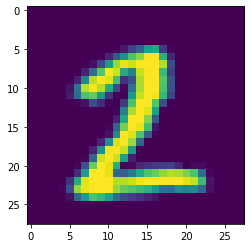

In [ ]:
a = 400000
plt.imshow(images_extras[a].reshape(28,28))
print(labels_images_extras[a])

## **Neural Network**

### **1. Class Criation**

In [ ]:
class Network(nn.Module):
    # Initialization of network layers
    def __init__(self):
        super().__init__()
      
        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = (3,3))
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3))
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3))

        # Totally connected layers
        self.fc1 = nn.Linear(in_features = 64*4*4, out_features = 256)
        self.norm1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(in_features = 256, out_features = 120)
        self.out = nn.Linear(in_features = 120, out_features = 10)
        
    def forward(self, t):
        
        # Activation function to the first convolutional layer
        t = F.relu(self.conv1(t))
        # Discretization function and sample resizing
        t = F.max_pool2d(t, kernel_size = (2,2), stride = 2)

        # Activation function to the second convolutional layer
        t = F.relu(self.conv2(t))
        # Discretization function and sample resizing
        t = F.max_pool2d(t, kernel_size = (2,2), stride = 1)

        # Activation function to the third convolutional layer
        t = F.relu(self.conv3(t))
        # Discretization function and sample resizing
        t = F.max_pool2d(t, kernel_size = (2,2), stride = 2)

        # Image leveling
        t = t.reshape(-1, 64*4*4)
        
        # Activation functions of totally connected layers
        t = F.relu(self.fc1(t))
        t = F.relu(self.norm1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        
        return t

## **2. Neural Network Training and Validation**

In [ ]:
def num_right_predictions(preds, labels):
    return preds.argmax(dim = 1).eq(labels).sum().item()

x_train, x_val, y_train, y_val = train_test_split(total_images, total_labels, test_size = 0.1, random_state = 33)

In [ ]:
# Processing the network with GPU
model = Network()
if torch.cuda.is_available():
    model = model.cuda()

# Optimization algorithm with AMSGrad, using an initial learning rate 1e-03
optimizer = optim.Adam(model.parameters(), lr = 0.001, amsgrad = True)

# It reduces the learning rate to 60% when the network stays 4 seasons without having a significant variation in the learning
# rate or when the learning rate increases from one time to another
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.6, patience = 4, verbose = True, min_lr = 1e-5)

# It reduces a learning rate to 95% at the end of each season
scheduler2 = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda = lambda epoch: .95)

# It reduces the learning rate to 70% in seasons 25 and 32
scheduler3 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = [25, 32], gamma = .7)

# Setting the batches that will be passed to the network during the training and validation
loader = DataLoader(DataSettrain(x_train, y_train), batch_size = 64, shuffle = True)
val_loader = DataLoader(DataSettrain(x_val, y_val), batch_size = 64, shuffle = True)

# It uses the gradient changes to update the synaptic weights
torch.set_grad_enabled(True)

# 35 times are used for the training and validation of the network
for epoch in range(35):
    
    total_loss = 0
    total_correct = 0
    
    # Start of the training process
    model.train()
    for batch in loader:
        images, labels = batch
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        
        preds = model(images)
        loss = F.cross_entropy(preds, labels.reshape(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += num_right_predictions(preds, labels.reshape(-1))

    val_loss = 0
    val_correct = 0

    # Start of the validation process
    model.eval()
    for val_batch in val_loader: 
        val_images, val_labels = val_batch
        if torch.cuda.is_available():
            val_images, val_labels = val_images.cuda(), val_labels.cuda()

        pred_validation = model(val_images)
        loss = F.cross_entropy(pred_validation, val_labels.reshape(-1))
        val_correct += num_right_predictions(pred_validation, val_labels.reshape(-1))

        val_loss += loss.item()

    scheduler1.step(loss)
    scheduler2.step()
    scheduler3.step()
      
    print('Época: ', epoch+1, ' |  Acertos test: ', total_correct, ' / ', len(x_train), ' |  Acurácia test: ',
          total_correct/len(x_train), ' |  loss: ', total_loss, ' |  Acurácia Validação: ', val_correct / len(x_val), " |  loss val: ", val_loss)     

Época:  1  |  Acertos Teste:  407374  /  415800  |  Acurácia Teste:  0.9797354497354497  |  loss:  435.27940188057255  |  Acurácia Validação:  0.9912987012987013  |  loss val:  20.35039794052136
Época:  2  |  Acertos Teste:  412807  /  415800  |  Acurácia Teste:  0.9928018278018278  |  loss:  146.69518577908457  |  Acurácia Validação:  0.9936363636363637  |  loss val:  14.640404801495606
Época:  3  |  Acertos Teste:  413857  /  415800  |  Acurácia Teste:  0.9953270803270803  |  loss:  93.52445064147832  |  Acurácia Validação:  0.9955194805194805  |  loss val:  10.385292921691871
Época:  4  |  Acertos Teste:  414449  /  415800  |  Acurácia Teste:  0.9967508417508417  |  loss:  65.74803570975564  |  Acurácia Validação:  0.9958874458874459  |  loss val:  8.948716248160963
Época:  5  |  Acertos Teste:  414756  /  415800  |  Acurácia Teste:  0.9974891774891775  |  loss:  48.98855781194561  |  Acurácia Validação:  0.9967099567099567  |  loss val:  7.5352247717646605
Época:  6  |  Acertos Tes

## **Digit Recognizing**

In [ ]:
predictions = model(torch.Tensor(test).reshape(28000, 1, 28, 28)).argmax(dim = 1)

### Sample of 40 test images with their predicted labels

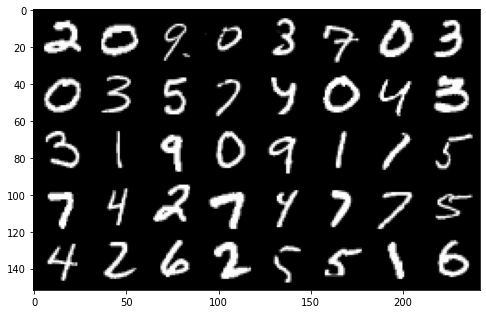

[[2 0 9 0 3 7 0 3]
 [0 3 5 7 4 0 4 3]
 [3 1 9 0 9 1 1 5]
 [7 4 2 7 4 7 7 5]
 [4 2 6 2 5 5 1 6]]


In [ ]:
loader_test = DataLoader(DataSettrain(test.reshape(28000, 1, 28, 28), np.arange(len(test))), batch_size=40)
batch = next(iter(loader_test))
images, labels = batch
grid = torchvision.utils.make_grid(images, n_row = 10)

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(torch.FloatTensor(grid), (1,2,0)))
plt.show()

print(np.array(predictions[0:40]).reshape(5,8))

## **Saving Outputs**
###  Criation of a CSV file containing ID and predicted label for each image

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),pd.Series(np.array(predictions), name = 'Label')],axis = 1)

submission.to_csv('../submission/submissao_torch_99.546%.csv',index=False)

torch.save(model, '../models/modelo_99.546%.pth')